In [6]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [7]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [8]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [9]:
# 셀 크기 설정
decom_size = width_bot_ag*3
cell_size = mp.Vector3(decom_size, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [10]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [ ]:
# design_layer = np.loadtxt("Objective45.txt")
# design_variables.update_weights(design_layer)

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)


          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

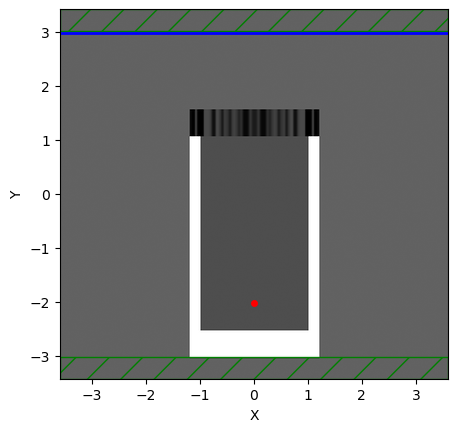

In [18]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(decom_size, 0)

dft_monitor = sims[0].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)


sims[0].plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0983422 s
lorentzian susceptibility: frequency=16.365, gamma

run 0 finished at t = 300.0 (30000 timesteps)
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

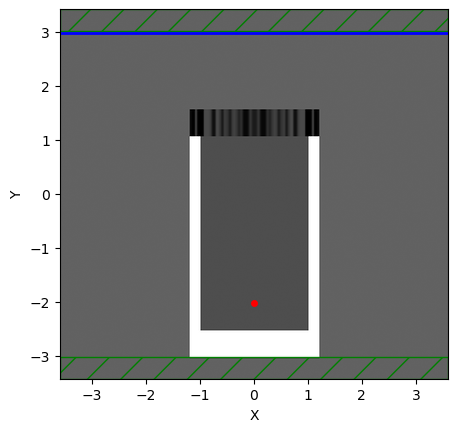

In [19]:
# sims[0].run(until_after_sources=mp.stop_when_fields_decayed(
#             10/df, mp.Ez, monitor_position_J, 1e-3
#         ))

# sims[0].run(until_after_sources = mp.stop_when_dft_decayed())
# sims[0].run(until_after_sources=mp.stop_when_dft_decayed())
sims[0].run(until=300)
Ez_dft =sims[0].get_dft_array(dft_monitor,mp.Ez,0)

sims[0].plot2D()

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

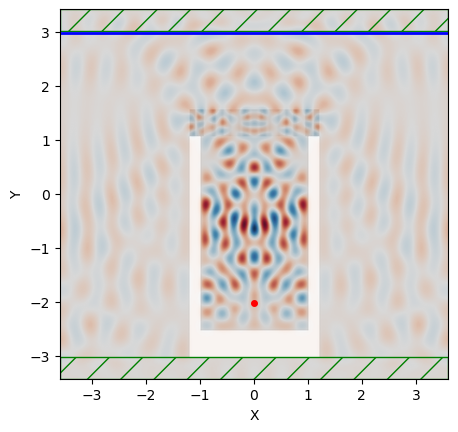

In [20]:
sims[0].plot2D(fields=mp.Ez)

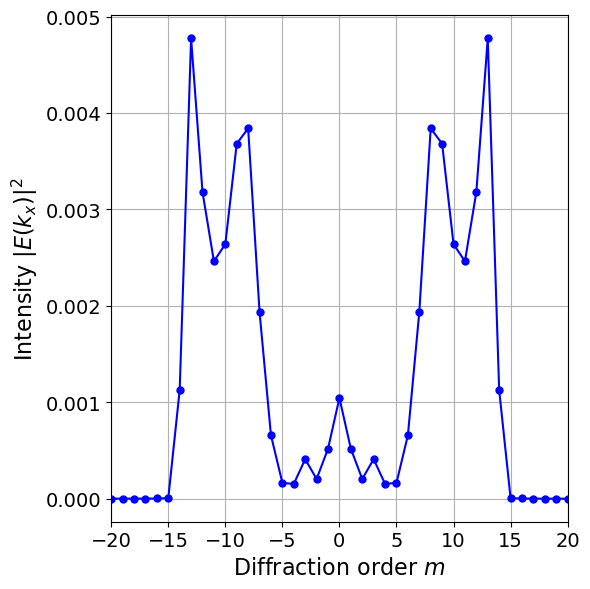

In [21]:
N        = len(Ez_dft)
dx       = 1.0 / resolution
E_k      = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))  
kx       = 2 * np.pi * kx_cycles                     

Delta_k = 2*np.pi/(N*dx)
p = kx/Delta_k

plt.figure(figsize=(6,6))
# plt.plot(p, np.abs(E_k)**2/max(np.abs(E_k)**2), 'ro-', markersize=5)
plt.plot(p, np.abs(E_k)**2, 'bo-', markersize=5)
plt.xlabel("Diffraction order $m$", fontsize=16)
plt.ylabel(r"Intensity $|E(k_x)|^2$",                   fontsize=16)
plt.xlim(-20, 20) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
p = [0.0153252 , 0.02165488, 0.03183664, 0.0491785 , 0.08063104,
       0.12931739, 0.21234441, 0.35555473, 0.5660916 , 0.79762535,
       0.9872151 , 1.        , 0.80398865, 0.4978186 , 0.27495631,
       0.24103001, 0.28834928, 0.230564  , 0.06527882, 0.0088741 ,
       0.16164143, 0.29012432, 0.18769896, 0.03505356, 0.06113697,
       0.12718428, 0.06113697, 0.03505356, 0.18769896, 0.29012432,
       0.16164143, 0.0088741 , 0.06527882, 0.230564  , 0.28834928,
       0.24103001, 0.27495631, 0.4978186 , 0.80398865, 1.        ,
       0.9872151 , 0.79762535, 0.5660916 , 0.35555473, 0.21234441,
       0.12931739, 0.08063104, 0.0491785 , 0.03183664, 0.02165488]
p_angle = [-9.00000000e+01, -8.64000000e+01, -8.28000000e+01, -7.92000000e+01,
       -7.56000000e+01, -7.20000000e+01, -6.84000000e+01, -6.48000000e+01,
       -6.12000000e+01, -5.76000000e+01, -5.40000000e+01, -5.04000000e+01,
       -4.68000000e+01, -4.32000000e+01, -3.96000000e+01, -3.60000000e+01,
       -3.24000000e+01, -2.88000000e+01, -2.52000000e+01, -2.16000000e+01,
       -1.80000000e+01, -1.44000000e+01, -1.08000000e+01, -7.20000000e+00,
       -3.60000000e+00,  1.42108547e-14,  3.60000000e+00,  7.20000000e+00,
        1.08000000e+01,  1.44000000e+01,  1.80000000e+01,  2.16000000e+01,
        2.52000000e+01,  2.88000000e+01,  3.24000000e+01,  3.60000000e+01,
        3.96000000e+01,  4.32000000e+01,  4.68000000e+01,  5.04000000e+01,
        5.40000000e+01,  5.76000000e+01,  6.12000000e+01,  6.48000000e+01,
        6.84000000e+01,  7.20000000e+01,  7.56000000e+01,  7.92000000e+01,
        8.28000000e+01,  8.64000000e+01]

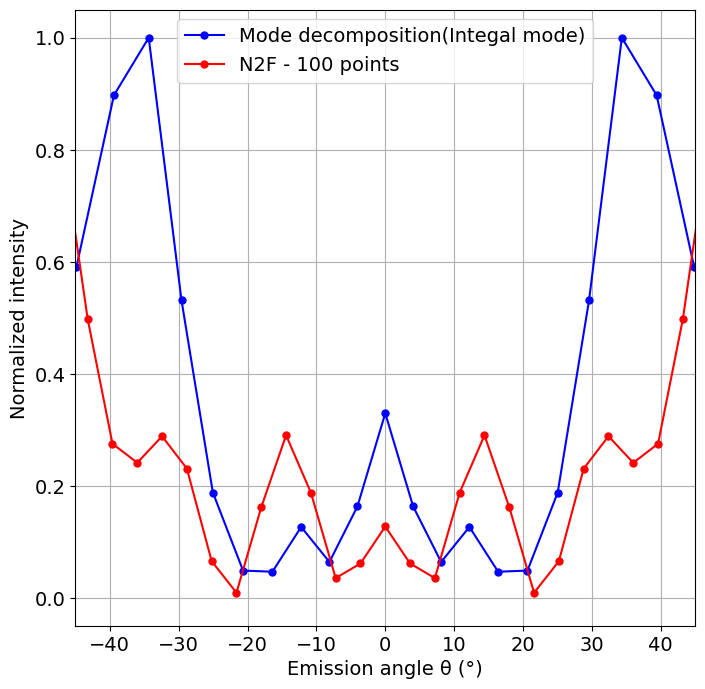

In [24]:
N         = len(Ez_dft)
dx        = 1.0 / resolution
E_k       = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx        = 2 * np.pi * kx_cycles

k0 = 2 * np.pi * fcen

ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))

P_fft = np.abs(E_k)**2 * (k0 * np.cos(np.radians(theta_deg)))

angle_min = -90
angle_max =  90
mask      = (theta_deg >= angle_min) & (theta_deg <= angle_max)

theta_sel  = theta_deg[mask]      
P_fft_sel  = P_fft[mask]
P_fft_sel /= np.max(P_fft_sel)    

plt.figure(figsize=(8,8))
plt.plot(
    theta_sel,
    P_fft_sel,
    linestyle='-',
    # linestyle='none',
    marker='o',
    markersize=5,
    color='blue',            # 선 색 지정
    markeredgecolor='blue',  # 마커 테두리 색
    # markerfacecolor='none',  # 마커 내부 빈칸
    label='Mode decomposition(Integal mode)'
)
# plt.title("[ -30° ~ +30° ]", fontsize = 20)
plt.plot(p_angle, p, 'ro-', markersize=5, label = "N2F - 100 points")
plt.xlabel("Emission angle θ (°)", fontsize=14)
plt.ylabel("Normalized intensity", fontsize=14)
plt.xlim(-45, 45)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize = 14)
plt.show()


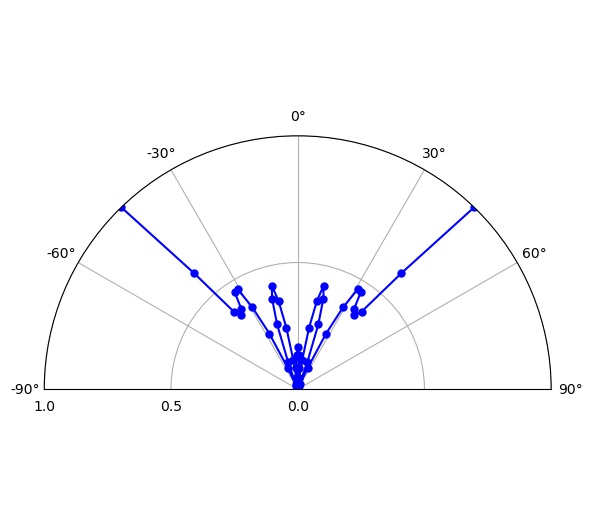

In [250]:
import numpy as np
import matplotlib.pyplot as plt

# — 기존 데이터 계산 —
N         = len(Ez_dft)
dx        = 1.0 / resolution
E_k       = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx        = 2 * np.pi * kx_cycles

k0 = 2 * np.pi * fcen

ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))

P_fft = np.abs(E_k)**2 * (k0 * np.cos(np.radians(theta_deg)))

# — 원하는 각도 범위만 선택 —
angle_min = -45
angle_max =  45
mask      = (theta_deg >= angle_min) & (theta_deg <= angle_max)

theta_sel  = theta_deg[mask]
P_fft_sel  = P_fft[mask]
P_fft_sel /= np.max(P_fft_sel)

# 라디안 변환
theta_rad = np.radians(theta_sel)

# — half-polar plot —
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='polar')

# θ=0을 위쪽(North)으로, 시계방향으로 각도 증가
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# –45°…+45°만 표시
ax.set_thetamin(-90)
ax.set_thetamax(90)

# 데이터 플롯
ax.plot(theta_rad, P_fft_sel, 'bo-', markersize=5)

# r축(반경) 설정
ax.set_rlim(0, 1)
ax.set_rticks([0, 0.5, 1.0])

# 타이틀 및 범례
# ax.legend(loc='lower right')

ax.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
np.inf

inf

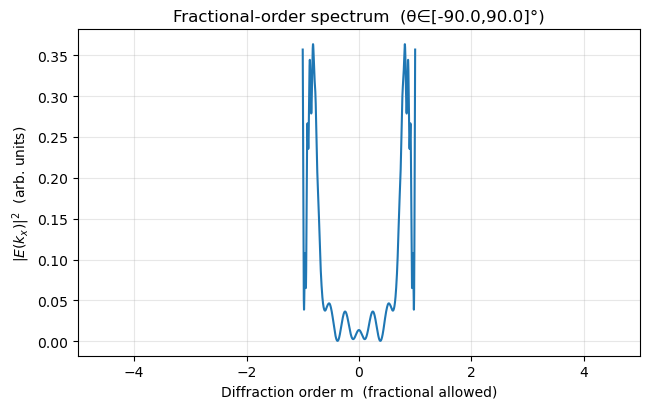

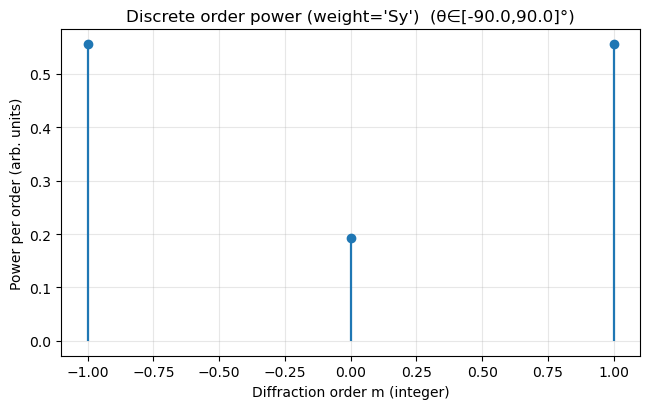

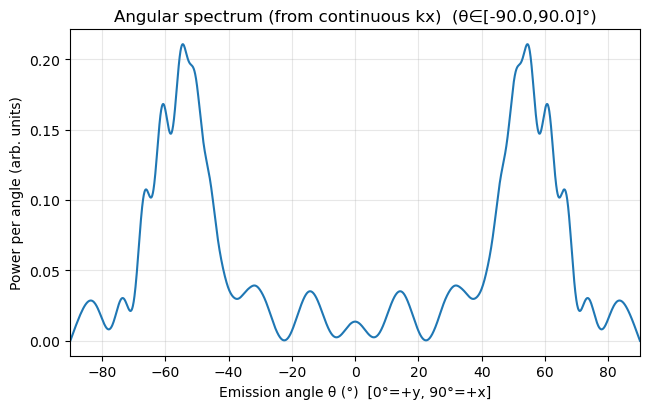

In [251]:
# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================


In [252]:
k = [0.01498845, 0.01634485, 0.01793277, 0.01985524, 0.02212646,
       0.02468411, 0.0274635 , 0.03048995, 0.03392984, 0.03806167,
       0.04317462, 0.04944824, 0.05688893, 0.06537691, 0.07481158,
       0.08526856, 0.0970582 , 0.11064189, 0.12647584, 0.14491736,
       0.16627817, 0.19098349, 0.21969848, 0.25328748, 0.29256736,
       0.337946  , 0.38913696, 0.44514282, 0.50456368, 0.56606919,
       0.62873019, 0.691969  , 0.75512391, 0.81686827, 0.87482604,
       0.9256397 , 0.96552256, 0.99107447, 1.        , 0.99143165,
       0.9657881 , 0.92434103, 0.86879091, 0.80111158, 0.72373708,
       0.63991706, 0.55390684, 0.47071689, 0.39540938, 0.33221445,
       0.28384334, 0.25124173, 0.23376363, 0.22953324, 0.23573374,
       0.24872987, 0.26416101, 0.2772398 , 0.28336804, 0.27893633,
       0.26201472, 0.2326976 , 0.19306673, 0.14689501, 0.09921573,
       0.0557799 , 0.02235467, 0.00386373, 0.00349424, 0.02198884,
       0.05732628, 0.10488916, 0.15808961, 0.20932777, 0.25112767,
       0.27729415, 0.28393052, 0.27014158, 0.23825575, 0.19347016,
       0.14294956, 0.09454585, 0.05539205, 0.03064093, 0.02258012,
       0.03028776, 0.04990335, 0.07547483, 0.10022284, 0.11796287,
       0.1243896 , 0.11796287, 0.10022284, 0.07547483, 0.04990335,
       0.03028776, 0.02258012, 0.03064093, 0.05539205, 0.09454585,
       0.14294956, 0.19347016, 0.23825575, 0.27014158, 0.28393052,
       0.27729415, 0.25112767, 0.20932777, 0.15808961, 0.10488916,
       0.05732628, 0.02198884, 0.00349424, 0.00386373, 0.02235467,
       0.0557799 , 0.09921573, 0.14689501, 0.19306673, 0.2326976 ,
       0.26201472, 0.27893633, 0.28336804, 0.2772398 , 0.26416101,
       0.24872987, 0.23573374, 0.22953324, 0.23376363, 0.25124173,
       0.28384334, 0.33221445, 0.39540938, 0.47071689, 0.55390684,
       0.63991706, 0.72373708, 0.80111158, 0.86879091, 0.92434103,
       0.9657881 , 0.99143165, 1.        , 0.99107447, 0.96552256,
       0.9256397 , 0.87482604, 0.81686827, 0.75512391, 0.691969  ,
       0.62873019, 0.56606919, 0.50456368, 0.44514282, 0.38913696,
       0.337946  , 0.29256736, 0.25328748, 0.21969848, 0.19098349,
       0.16627817, 0.14491736, 0.12647584, 0.11064189, 0.0970582 ,
       0.08526856, 0.07481158, 0.06537691, 0.05688893, 0.04944824,
       0.04317462, 0.03806167, 0.03392984, 0.03048995, 0.0274635 ,
       0.02468411, 0.02212646, 0.01985524, 0.01793277, 0.01634485,
       0.01498845]
k_angle = [-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25.,
       -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.]

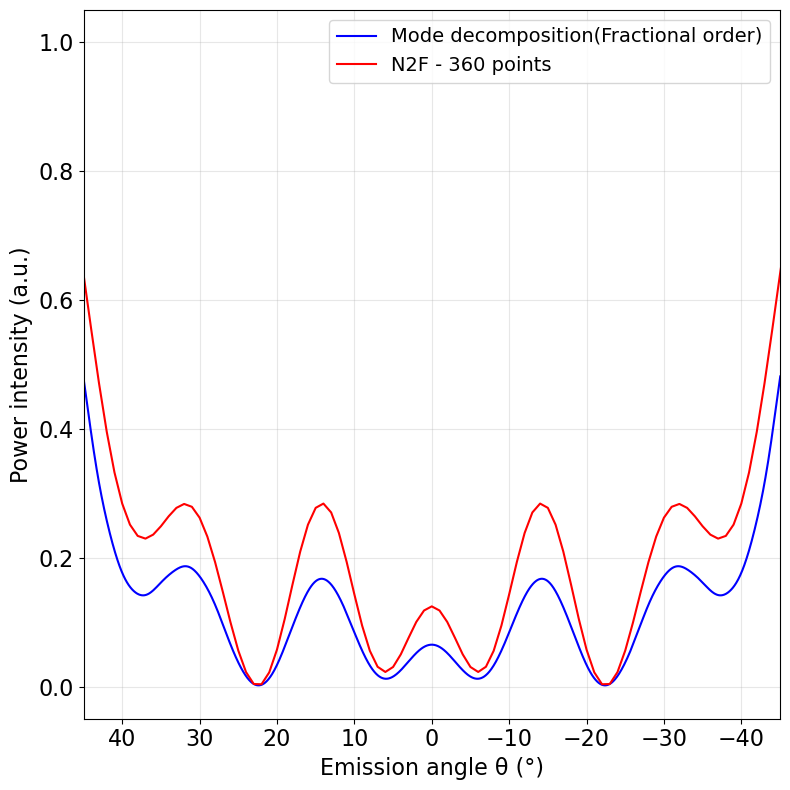

In [253]:
plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
plt.plot(k_angle, k, 'r-', label = 'N2F - 360 points')
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

In [276]:
7.2/12

0.6